# Evaluación del modelo

In [1]:
import re
import math
import time
import glob
import gzip
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import os
import h5py

from sklearn_extensions.kernel_regression import KernelRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf

# Empezamos la evaluación del modelo

## Selecciono la red que estoy evaluando

In [2]:
red='zenith_nodrop'

## Creo las carpetas para guardas los plots de los resultados

In [3]:
try:
    os.mkdir('fig')
except FileExistsError:
    print('El directorio "fig" ya existe')

try:
    os.mkdir('fig/'+red)
except FileExistsError:
    print('El directorio "fig/'+red+'" ya existe')

El directorio "fig" ya existe
El directorio "fig/zenith_nodrop" ya existe


## Declaro donde están las variables reales y cargo los datos de la red en *y_predict_N*

In [4]:
test_names = glob.glob("data_norm_hdf5/test_data_fixed/*.hdf5")

npzfile = np.load('pi/PI_'+red+'.npz')
y_predict = npzfile['y_predict']

## Cojo los valores de testeo

Algunas cosas cambiarán debido a los cambios en el preprocesado y las normalizaciones

In [5]:
with h5py.File(test_names[0], 'r') as test_data:
    y_test = test_data["y"][...]
    bbfit_uz = test_data["X2"][:,0]

for name in test_names[1:]:
    with h5py.File(name, 'r') as test_data:
        y_aux = test_data["y"][...]
        uz_aux = test_data["X2"][:,0]
    y_test = np.append(y_test, y_aux, axis=0)
    bbfit_uz = np.append(bbfit_uz, uz_aux, axis=0)

# Energia real
energy = y_test[:,3]

## Obteniendo el resto de parámetros

Obtengo el valor predicho como la media de los 100 valores que se predicen con DropOut activo, la Sigma como la media de las 100 Sigmas, y lo que llamamos *prediction interval* (PI) como la desviación en los valores predichos.

Los ángulos se pasan a grados, auque para cálculo de propagación de errores y otras cosas hay que usarlos en radianes tal y como salen de la red.

In [6]:
# Zenith y desviacion predichas
zenith_p = y_predict[0] * (180.0/np.pi)
zenith_std = y_predict[1] * (180.0/np.pi)

In [7]:
# Calculo los valores de Z
zeta = np.cos(y_predict[0])
zeta_std = y_predict[1]*np.sin(y_predict[0])

In [8]:
zeta_error =  zeta - y_test[:,2]
bbfit_zeta_error = bbfit_uz - y_test[:,2]

zeta_error_abs = np.abs(zeta_error)
bbfit_zeta_error_abs = np.abs(bbfit_zeta_error)

In [9]:
# Zenith reales (zenith_true)
zenith_t = np.arccos(y_test[:,2]) * (180/np.pi)

# Zenith BBfit
bbfit_z_p = np.arccos(bbfit_uz) * (180/np.pi)

## Obteniendo las métricas MAE y MSE

In [10]:
print('Metrics Zenith:')
metrics = np.zeros((2,2), dtype = np.float32)
metrics[0,0] = mean_absolute_error(zenith_t, zenith_p)  # MAE Zenith
metrics[1,0] = mean_absolute_error(zenith_t, bbfit_z_p) # MAE BBift Zenith

metrics[0,1] = mean_squared_error(zenith_t, zenith_p, squared = False)  # RMSE Zenith
metrics[1,1] = mean_squared_error(zenith_t, bbfit_z_p, squared = False) # RMSE BBfit Zenith

metrics

Metrics Zenith:


array([[ 8.38509 , 12.645008],
       [15.483752, 24.387743]], dtype=float32)

In [11]:
print('Metrics Z:')
metrics = np.zeros((2,2), dtype = np.float32)
metrics[0,0] = mean_absolute_error(y_test[:,2], zeta) # MAE Z
metrics[1,0] = mean_absolute_error(y_test[:,2], bbfit_uz)          # MAE BBift Z

metrics[0,1] = mean_squared_error(y_test[:,2], zeta, squared = False) # RMSE Z
metrics[1,1] = mean_squared_error(y_test[:,2], bbfit_uz, squared = False)          # RMSE BBfit Z

metrics

Metrics Z:


array([[0.10914429, 0.17657809],
       [0.19805771, 0.33526382]], dtype=float32)

### Errores en ángulos y variable chi$^2$

In [12]:
# Chi^2
with h5py.File(test_names[0], 'r') as test_data:
    txi2 = test_data["X2"][:,-1]

for name in test_names[1:]:
    with h5py.File(name, 'r') as test_data:
        tx_aux = test_data["X2"][:,-1]
    txi2 = np.append(txi2, tx_aux, axis=0)

# Errores en zenith sin valor absoluto
z_error = zenith_p - zenith_t 

# Error en zenith de BBfit sin valor absoluto
bbfit_z_error = bbfit_z_p - zenith_t

# Errores absolutos en zenith 
z_error_abs = np.abs(z_error)

# Error absoluto en zenith de BBfit
bbfit_z_error_abs = np.absolute(bbfit_z_error)

## Funciones para dibujar los datos agrupados

A esta función no es necesario pasarle los datos ordenados, los ordena automaticamente en el eje X maneteniendo sus correspondientes valores en el eje Y.

Como hay demasidados valores como para pintarlos punto a punto, lo que hacemos es una estadística. Agrupamos los valores en intervalos en el eje X y representamos la media, mediana y cuartiles (o desviación estandar) de sus valores en el eje Y.

### Con media y desviación estandar

In [13]:
def smooth_values (x, y, n_bins):
#     step = int(np.ceil(x.shape[0]/n_bins))
    step = (x.max()-x.min())/n_bins
    sep = np.arange(x.min(),x.max()+step, step)
    sort_ind = np.argsort(x)
    n_x = np.ones((n_bins), dtype = np.float32)
    n_y = np.ones((n_bins), dtype = np.float32)
    y_err = np.ones((n_bins), dtype = np.float32)
    x_err = np.ones((n_bins), dtype = np.float32)
#     print(sep, x[sort_ind], y [sort_ind])
    count = 0
    suma=[]
    for i in range(n_bins):
        last_ind = count
        if i == n_bins - 1:
            n_x[i] = np.mean(x[sort_ind[count:]])
            x_err[i] = np.std(x[sort_ind[count:]])
            n_y[i] = np.mean(y[sort_ind[count:]])
            y_err[i] = np.std(y[sort_ind[count:]])
#             print(x[sort_ind[count:]], last_ind, count , x[sort_ind[count:]].shape[0] ) 
#             print(y[sort_ind[count:]], last_ind, count , y[sort_ind[count:]].shape[0] )
            #print('Bin: ', i, ' Muestras en este bin:',len(x)-count)
            suma.append(str(len(x)-count))
            break
        for ind in range (count, x.shape[0]):
            if x[sort_ind[ind]] >= sep[i] and x[sort_ind[ind]] < sep[i+1]:
                count = ind
            else:
                break
        
        n_x[i] = np.mean(x[sort_ind[last_ind:count+1]])
        x_err[i] = np.std(x[sort_ind[last_ind:count+1]])
        n_y[i] = np.mean(y[sort_ind[last_ind:count+1]])
        y_err[i] = np.std(y[sort_ind[last_ind:count+1]])
        #print('Bin: ', i, ' Muestras en este bin:',count+1-last_ind)
        suma.append(str(count+1-last_ind))
        count +=1
    #print('Numero de muestras por bin: ', suma)
    return n_x, n_y, x_err, y_err

### Con mediana y cuartiles

In [14]:
def smooth_median (x, y, n_bins):
#     step = int(np.ceil(x.shape[0]/n_bins))
    step = (x.max()-x.min())/n_bins
    sep = np.arange(x.min(),x.max()+step, step)
    sort_ind = np.argsort(x)
    n_x = np.ones((n_bins), dtype = np.float32)
    n_y = np.ones((n_bins), dtype = np.float32)
    y_err = np.ones((n_bins), dtype = np.float32)
    x_err = np.ones((n_bins), dtype = np.float32)
#     print(sep, x[sort_ind], y [sort_ind])
    count = 0
    suma=[]
    for i in range(n_bins):
        last_ind = count
        if i == n_bins - 1:
            n_x[i] = np.mean(x[sort_ind[count:]])
            x_err[i] = np.std(x[sort_ind[count:]])
            n_y[i] = np.mean(y[sort_ind[count:]])
            y_err[i] = np.std(y[sort_ind[count:]])
#             print(x[sort_ind[count:]], last_ind, count , x[sort_ind[count:]].shape[0] ) 
#             print(y[sort_ind[count:]], last_ind, count , y[sort_ind[count:]].shape[0] )
            #print('Bin: ', i, ' Muestras en este bin:',len(x)-count)
            suma.append(str(len(x)-count))
            break
        for ind in range (count, x.shape[0]):
            if x[sort_ind[ind]] >= sep[i] and x[sort_ind[ind]] < sep[i+1]:
                count = ind
            else:
                break
        
        n_x[i] = np.mean(x[sort_ind[last_ind:count+1]])
        
        n_y[i] = np.median(y[sort_ind[last_ind:count+1]]) #--> mediana
        x_err[i] = np.quantile(y[sort_ind[last_ind:count+1]],0.25)  #--> primer cuartil
        y_err[i] = np.quantile(y[sort_ind[last_ind:count+1]],0.75)  #--> tercer cuartil
        #print('Bin: ', i, ' Muestras en este bin:',count+1-last_ind)
        suma.append(str(count+1-last_ind))
        count +=1
    #print('Numero de muestras por bin: ', suma)
    return n_x, n_y, x_err, y_err

# Plots de Zenith

### Plot de chi$^2$

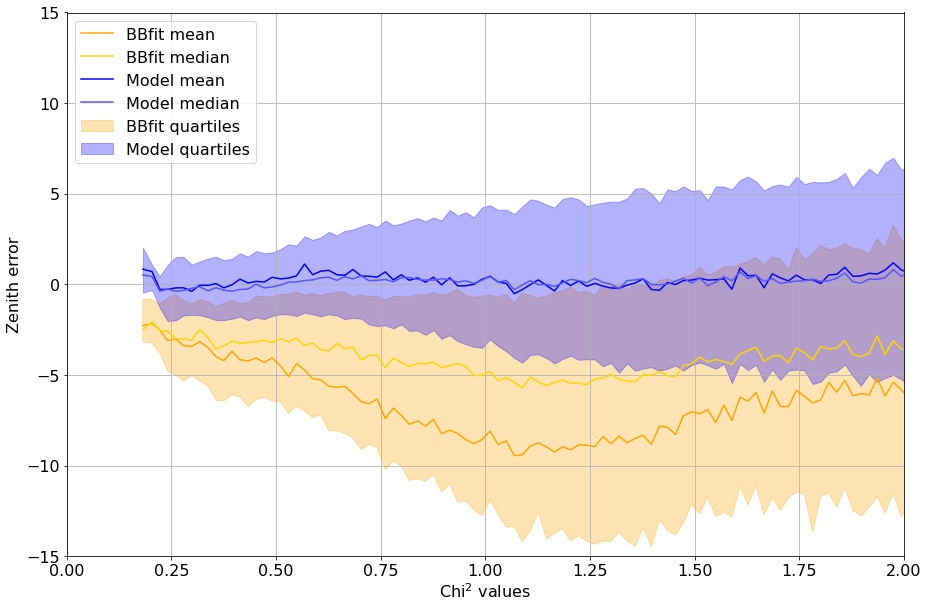

In [15]:
plt.close('all')

#Cambio el tamanyo de fuente
plt.rcParams.update({'font.size': 16})

# Cambio el tamanyo de la figura
plt.figure(figsize=(15,10))

# Mascara para coger solo los valores de chi^2 inferiores a 20
msk_txi2 = txi2<=2.1
value = txi2[msk_txi2]

# Numero de intervalos en los que agrupo los datos
n_bins = 100 

x, y, x_err, y_err = smooth_values (value, bbfit_z_error[msk_txi2], n_bins) #cojo los valores
plt.plot(x, y, 'orange')
x, y, q1, q3 = smooth_median(value, bbfit_z_error[msk_txi2], n_bins)
plt.plot(x, y, '#ffd500')
plt.fill_between(x, q3,q1,color='orange',alpha=0.3)

x, y, x_err, y_err = smooth_values (value, z_error[msk_txi2], n_bins) #cojo los valores
plt.plot(x, y, 'blue')
x, y, q1, q3 = smooth_median(value, z_error[msk_txi2], n_bins) #cojo los valores
plt.plot(x, y, '#5555ff')
plt.fill_between(x, q3, q1,color='blue',alpha=0.3)

plt.ylim(-15, 15)
plt.xlim(0, 2)
plt.ylabel('Zenith error')
plt.xlabel('Chi$^2$ values')
plt.legend(("BBfit mean","BBfit median", "Model mean","Model median",'BBfit quartiles', 'Model quartiles'),loc='upper left')
plt.grid()

# Guardo la figura y la muestro
plt.savefig('fig/'+red+'/chi2_Zenith.png')
plt.show(); #muestro las figuras

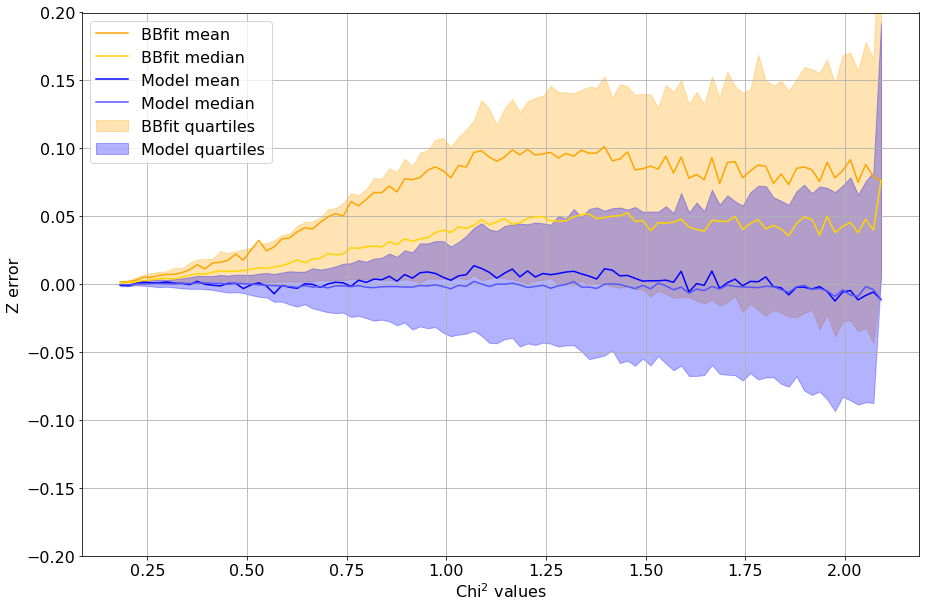

In [16]:
plt.close('all')

#Cambio el tamanyo de fuente
plt.rcParams.update({'font.size': 16})

# Cambio el tamanyo de la figura
plt.figure(figsize=(15,10))

# Mascara para coger solo los valores de chi^2 inferiores a 20
msk_txi2 = txi2<=2.1
value = txi2[msk_txi2]

# Numero de intervalos en los que agrupo los datos
n_bins = 100 

x, y, x_err, y_err = smooth_values (value, bbfit_zeta_error[msk_txi2], n_bins) #cojo los valores
plt.plot(x, y, 'orange')
x, y, q1, q3 = smooth_median(value, bbfit_zeta_error[msk_txi2], n_bins)
plt.plot(x, y, '#ffd500')
plt.fill_between(x, q3,q1,color='orange',alpha=0.3)

x, y, x_err, y_err = smooth_values (value, zeta_error[msk_txi2], n_bins) #cojo los valores
plt.plot(x, y, 'blue')
x, y, q1, q3 = smooth_median(value, zeta_error[msk_txi2], n_bins) #cojo los valores
plt.plot(x, y, '#5555ff')
plt.fill_between(x, q3, q1,color='blue',alpha=0.3)

plt.ylim(-0.2, 0.2)
plt.ylabel('Z error')
plt.xlabel('Chi$^2$ values')
plt.legend(("BBfit mean","BBfit median", "Model mean","Model median",'BBfit quartiles', 'Model quartiles'),loc='upper left')
plt.grid()

# Guardo la figura y la muestro
plt.savefig('fig/'+red+'/chi2_Z.png')
plt.show(); #muestro las figuras

### Plot de PI

### Plot de epsilon

[ 0.5809791   0.72545654  0.8237511   0.93106705  1.0185363   1.1204187
  1.2174205   1.3139002   1.4159036   1.5136566   1.6114731   1.711291
  1.8080198   1.9059396   2.0046277   2.1037054   2.2022393   2.2995138
  2.4009876   2.4985244   2.5947578   2.6955037   2.7949104   2.8919444
  2.9900808   3.0908306   3.1867168   3.2870238   3.3845317   3.485284
  3.5839782   3.6809473   3.7803211   3.879652    3.9789228   4.0774016
  4.1756234   4.272384    4.37351     4.47071     4.571178    4.667893
  4.7674885   4.866784    4.9665375   5.0627685   5.1622653   5.261571
  5.360697    5.45818     5.556235    5.654124    5.754376    5.8525076
  5.951207    6.0504255   6.1495533   6.248015    6.346821    6.4467773
  6.5453215   6.6443753   6.7409015   6.839462    6.9396415   7.038115
  7.136191    7.234356    7.3342886   7.43304     7.5313478   7.6298213
  7.729415    7.82729     7.925101    8.024444    8.123184    8.221992
  8.320579    8.419286    8.518238    8.616902    8.714876    8.813526

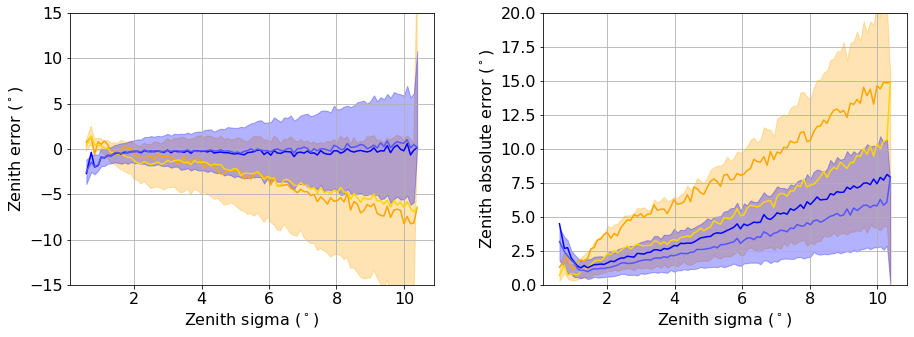

In [17]:
plt.close('all')

#Cambio el tamanyo de fuente
plt.rcParams.update({'font.size': 16})

# Cambio el tamanyo de la figura
plt.figure(figsize=(15,5))

# Numero de intervalos en los que agrupo los datos
n_bins = 100

msk_txi2 = txi2<=2.0
casos = np.sum(msk_txi2)

z_msk = np.abs(zenith_std) < np.sort(np.abs(zenith_std))[casos]

plt.subplot(1, 2, 1)
x, y, x_err, y_err = smooth_values (zenith_std[z_msk], bbfit_z_error[z_msk], n_bins) #cojo los valores
plt.plot(x, y, 'orange')
x, y, q1, q3 = smooth_median (zenith_std[z_msk], bbfit_z_error[z_msk], n_bins) #cojo los valores
plt.plot(x, y, '#ffd500')
plt.fill_between(x, q3, q1,color='orange',alpha=0.3)

x, y, x_err, y_err = smooth_values (zenith_std[z_msk], z_error[z_msk], n_bins) #cojo los valores
print(x)
plt.plot(x, y, 'blue')
x, y, q1, q3 = smooth_median (zenith_std[z_msk], z_error[z_msk], n_bins) #cojo los valores
plt.plot(x, y, '#5555ff')
plt.fill_between(x, q3, q1,color='blue',alpha=0.3)

plt.ylim(-15, 15)
plt.ylabel('Zenith error ($^\circ$)')
plt.xlabel('Zenith sigma ($^\circ$)')
#plt.legend(("Model error", 'Model error deviation'),loc='upper right')
plt.grid()

plt.subplot(1, 2, 2)
x, y, x_err, y_err = smooth_values (zenith_std[z_msk], bbfit_z_error_abs[z_msk], n_bins) #cojo los valores
plt.plot(x, y, 'orange')
x, y, q1, q3 = smooth_median (zenith_std[z_msk], bbfit_z_error_abs[z_msk], n_bins) #cojo los valores
plt.plot(x, y, '#ffd500')
plt.fill_between(x, q3, q1, color='orange',alpha=0.3)

x, y, x_err, y_err = smooth_values (zenith_std[z_msk], z_error_abs[z_msk], n_bins) #cojo los valores
plt.plot(x, y, 'blue')
x, y, q1, q3 = smooth_median (zenith_std[z_msk], z_error_abs[z_msk], n_bins) #cojo los valores
plt.plot(x, y, '#5555ff')
plt.fill_between(x, q3, q1, color='blue',alpha=0.3)

#plt.fill_between(x, y+y_err,y-y_err,color='blue',alpha=0.3)
plt.ylim(0, 20)
plt.ylabel('Zenith absolute error ($^\circ$)')
plt.xlabel('Zenith sigma ($^\circ$)')
#plt.legend(("Model error", 'Model error deviation'),loc='upper right')
plt.grid()

plt.subplots_adjust(hspace=0.25,wspace=0.3)
# Guardo la figura y la muestro
plt.savefig('fig/'+red+'/eps_Zenith.png')
plt.show(); #muestro las figuras

[0.00081638 0.00209994 0.00338147 0.00468663 0.00600807 0.00731754
 0.00864857 0.00997373 0.01129257 0.01261711 0.0139562  0.01527758
 0.01661886 0.01794657 0.0192625  0.02059201 0.02192341 0.02327101
 0.02461751 0.02591238 0.02725413 0.02858274 0.02991359 0.03124884
 0.03257355 0.03389698 0.03521543 0.03655175 0.03788083 0.03921966
 0.04055685 0.04186548 0.04321172 0.04453781 0.04584209 0.04719657
 0.04854739 0.04985245 0.05117461 0.05249437 0.05384146 0.05516835
 0.0564772  0.05782864 0.05915638 0.06049365 0.06180176 0.06315323
 0.06447807 0.06578518 0.06711782 0.06846267 0.06979716 0.07112413
 0.07244029 0.07377013 0.07510275 0.07642942 0.07776035 0.07909577
 0.08043317 0.08172784 0.08308416 0.08441362 0.0857411  0.08705388
 0.08839703 0.08973774 0.09104995 0.09237953 0.0937222  0.09505149
 0.0963624  0.09771116 0.09901362 0.10036618 0.10169525 0.1030144
 0.10434835 0.10569115 0.10701634 0.10832026 0.10966361 0.11098309
 0.1123049  0.11365598 0.11497299 0.11629441 0.11765132 0.11896

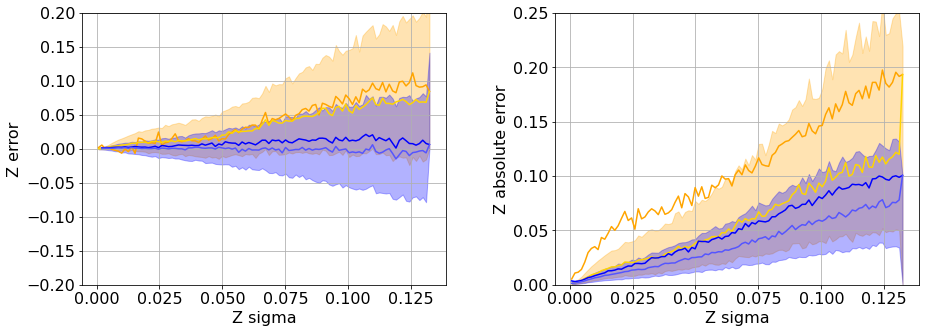

In [18]:
plt.close('all')

#Cambio el tamanyo de fuente
plt.rcParams.update({'font.size': 16})

# Cambio el tamanyo de la figura
plt.figure(figsize=(15,5))

# Numero de intervalos en los que agrupo los datos
n_bins = 100

msk_txi2 = txi2<=2.0
casos = np.sum(msk_txi2)

z_msk = np.abs(zeta_std) < np.sort(np.abs(zeta_std))[casos]

plt.subplot(1, 2, 1)
x, y, x_err, y_err = smooth_values (zeta_std[z_msk], bbfit_zeta_error[z_msk], n_bins) #cojo los valores
plt.plot(x, y, 'orange')
x, y, q1, q3 = smooth_median (zeta_std[z_msk], bbfit_zeta_error[z_msk], n_bins) #cojo los valores
plt.plot(x, y, '#ffd500')
plt.fill_between(x, q3,q1,color='orange',alpha=0.3)

x, y, x_err, y_err = smooth_values (zeta_std[z_msk], zeta_error[z_msk], n_bins) #cojo los valores
plt.plot(x[1:], y[1:], 'blue')
x, y, q1, q3 = smooth_median (zeta_std[z_msk], zeta_error[z_msk], n_bins) #cojo los valores
plt.plot(x[1:], y[1:], '#5555ff')
plt.fill_between(x, q3,q1,color='blue',alpha=0.3)

plt.ylim(-0.2, 0.2)
plt.ylabel('Z error')
plt.xlabel('Z sigma')
#plt.legend(("Model (ReLU) error", 'Model(ReLU) error deviation'),loc='upper right')
plt.grid()

plt.subplot(1, 2, 2)
x, y, x_err, y_err = smooth_values (zeta_std[z_msk], bbfit_zeta_error_abs[z_msk], n_bins) #cojo los valores
plt.plot(x, y, 'orange')
x, y, q1, q3 = smooth_median (zeta_std[z_msk], bbfit_zeta_error_abs[z_msk], n_bins) #cojo los valores
plt.plot(x, y, '#ffd500')
plt.fill_between(x, q3,q1,color='orange',alpha=0.3)

x, y, x_err, y_err = smooth_values (zeta_std[z_msk], zeta_error_abs[z_msk], n_bins) #cojo los valores
print(x)
plt.plot(x, y, 'blue')
x, y, q1, q3 = smooth_median (zeta_std[z_msk], zeta_error_abs[z_msk], n_bins) #cojo los valores
plt.plot(x, y, '#5555ff')
plt.fill_between(x, q3,q1,color='blue',alpha=0.3)

plt.ylim(0, 0.25)
plt.ylabel('Z absolute error')
plt.xlabel('Z sigma')
#plt.legend(("Model (ReLU) error", 'Model(ReLU) error deviation'),loc='upper right')
plt.grid()

plt.subplots_adjust(hspace=0.25,wspace=0.3)
# Guardo la figura y la muestro
plt.savefig('fig/'+red+'/eps_Z.png')
plt.show(); #muestro las figuras

### Histogramas 2D: error vs PI/Epsilon

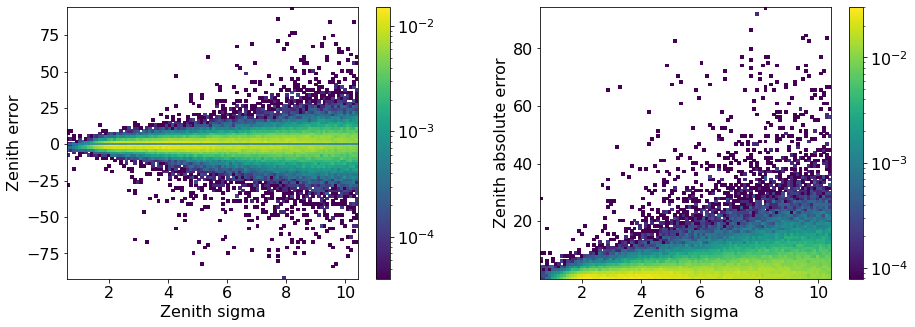

In [19]:
plt.close('all')

#Cambio el tamanyo de fuente
plt.rcParams.update({'font.size': 16})

# Cambio el tamanyo de la figura
plt.figure(figsize=(15,5))

# Numero de intervalos en los que agrupo los datos
n_bins = 100

msk_txi2 = txi2<=2.0
casos = np.sum(msk_txi2)
z_msk = np.abs(zenith_std) < np.sort(np.abs(zenith_std))[casos]

plt.subplot(1, 2, 1)
plt.hist2d(zenith_std[z_msk], z_error[z_msk], bins = n_bins, density = True, norm = matplotlib.colors.LogNorm())
#plt.xlim(-1,1)
#plt.ylim(-1,1)
plt.plot(plt.gca().get_xlim(), (0,0))
plt.ylabel('Zenith error')
plt.xlabel('Zenith sigma')
plt.colorbar()


plt.subplot(1, 2, 2)
plt.hist2d(zenith_std[z_msk], z_error_abs[z_msk], bins = n_bins, density = True, norm = matplotlib.colors.LogNorm())
#plt.xlim(-1,1)
#plt.ylim(-1,1)
plt.ylabel('Zenith absolute error')
plt.xlabel('Zenith sigma')
plt.colorbar()

plt.subplots_adjust(hspace=0.25,wspace=0.3)
# Guardo la figura y la muestro
plt.savefig('fig/'+red+'/colors_eps_Zenith.png')
plt.show(); #muestro las figuras

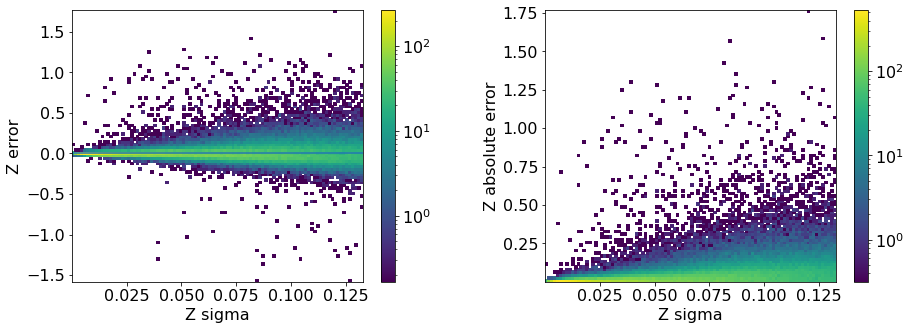

In [20]:
plt.close('all')

#Cambio el tamanyo de fuente
plt.rcParams.update({'font.size': 16})

# Cambio el tamanyo de la figura
plt.figure(figsize=(15,5))

# Numero de intervalos en los que agrupo los datos
n_bins = 100

msk_txi2 = txi2<=2.0
casos = np.sum(msk_txi2)
z_msk = np.abs(zeta_std) < np.sort(np.abs(zeta_std))[casos]

plt.subplot(1, 2, 1)
plt.hist2d(zeta_std[z_msk], zeta_error[z_msk], bins = n_bins, density = True, norm = matplotlib.colors.LogNorm())
#plt.xlim(-1,1)
#plt.ylim(-1,1)
plt.plot(plt.gca().get_xlim(), (0,0))
plt.ylabel('Z error')
plt.xlabel('Z sigma')
plt.colorbar()


plt.subplot(1, 2, 2)
plt.hist2d(zeta_std[z_msk], zeta_error_abs[z_msk], bins = n_bins, density = True, norm = matplotlib.colors.LogNorm())
#plt.xlim(-1,1)
#plt.ylim(-1,1)
plt.ylabel('Z absolute error')
plt.xlabel('Z sigma')
plt.colorbar()

plt.subplots_adjust(hspace=0.25,wspace=0.3)
# Guardo la figura y la muestro
plt.savefig('fig/'+red+'/colors_eps_Z.png')
plt.show(); #muestro las figuras

### Plots de energías

Porcentaje de eventos con energía inferior a 1000: 81.55%


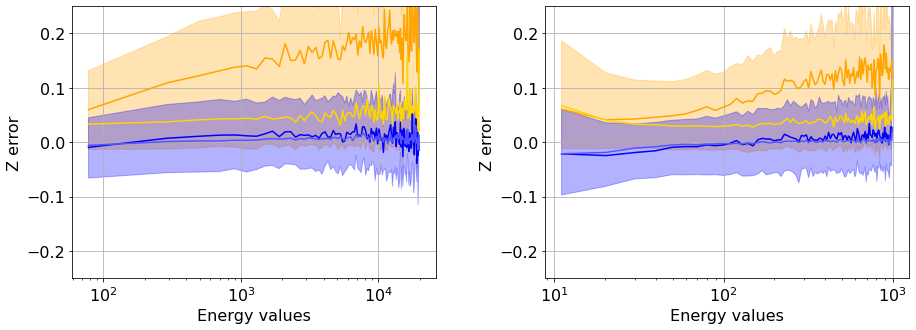

In [21]:
plt.close('all')
plt.figure(figsize=(15,5))
plt.rcParams.update({'font.size': 16})

msk_energ = energy<=1000
n_bins = 100

plt.subplot(1, 2, 1)
x, y, x_err, y_err = smooth_values (energy, bbfit_zeta_error, n_bins) #cojo los valores
plt.plot(x, y,'orange')
x, y, q1, q3 = smooth_median (energy, bbfit_zeta_error, n_bins) #cojo los valores
plt.plot(x, y,'#ffd500')
plt.fill_between(x, q3, q1,color='orange',alpha=0.3)

x, y, x_err, y_err = smooth_values (energy, zeta_error, n_bins) #cojo los valores
plt.plot(x, y,'blue')
x, y, q1, q3 = smooth_median (energy, zeta_error, n_bins) #cojo los valores
plt.plot(x, y, '#5555ff')
plt.fill_between(x, q3, q1,color='blue',alpha=0.3)

plt.xscale("log")
plt.ylim(-0.25, 0.25)
plt.ylabel('Z error')
plt.xlabel('Energy values')
#plt.legend(("BBfit error","Model (ReLU) error",'BBfit error deviation', 'Model (ReLU) error deviation'),loc='lower right')
plt.grid()

plt.subplot(1, 2, 2)
pct = np.sum(msk_energ)/len(msk_energ)*100.0
print('Porcentaje de eventos con energía inferior a 1000: '+str(round(pct,2))+'%')

x, y, x_err, y_err = smooth_values (energy[msk_energ], bbfit_zeta_error[msk_energ], n_bins) #cojo los valores
plt.plot(x, y,'orange')
x, y, q1, q3 = smooth_median (energy[msk_energ], bbfit_zeta_error[msk_energ], n_bins) #cojo los valores
plt.plot(x, y,'#ffd500')
plt.fill_between(x, q3, q1,color='orange',alpha=0.3)

x, y, x_err, y_err = smooth_values (energy[msk_energ], zeta_error[msk_energ], n_bins) #cojo los valores
plt.plot(x, y,'blue')
x, y, q1, q3 = smooth_median (energy[msk_energ], zeta_error[msk_energ], n_bins) #cojo los valores
plt.plot(x, y, '#5555ff')
plt.fill_between(x, q3, q1,color='blue',alpha=0.3)

plt.xscale("log")
plt.ylim(-0.25, 0.25)
plt.ylabel('Z error')
plt.xlabel('Energy values')
#plt.legend(("BBfit error","Model (ReLU) error",'BBfit error deviation', 'Model (ReLU) error deviation'),loc='lower right')
plt.grid()

plt.subplots_adjust(hspace=0.25,wspace=0.3)
plt.savefig('fig/'+red+'/energy.png')
plt.show(); #muestro las figuras

Porcentaje de eventos con energía inferior a 1000: 81.55%


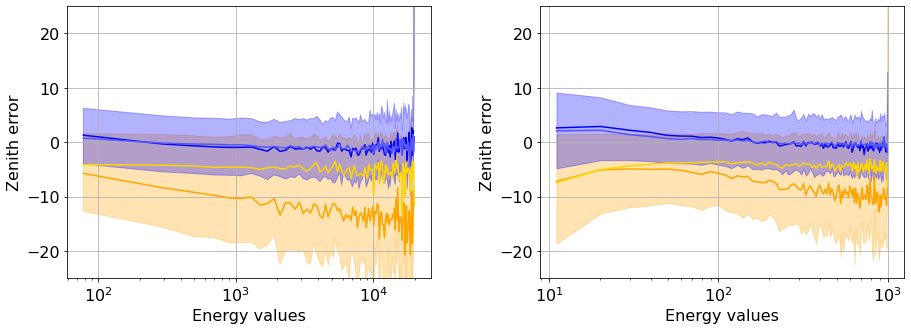

In [22]:
plt.close('all')
plt.figure(figsize=(15,5))
plt.rcParams.update({'font.size': 16})

msk_energ = energy<=1000
n_bins = 100

plt.subplot(1, 2, 1)
x, y, x_err, y_err = smooth_values (energy, bbfit_z_error, n_bins) #cojo los valores
plt.plot(x, y,'orange')
x, y, q1, q3 = smooth_median (energy, bbfit_z_error, n_bins) #cojo los valores
plt.plot(x, y,'#ffd500')
plt.fill_between(x, q3, q1,color='orange',alpha=0.3)

x, y, x_err, y_err = smooth_values (energy, z_error, n_bins) #cojo los valores
plt.plot(x, y,'blue')
x, y, q1, q3 = smooth_median (energy, z_error, n_bins) #cojo los valores
plt.plot(x, y, '#5555ff')
plt.fill_between(x, q3, q1,color='blue',alpha=0.3)

plt.xscale("log")
plt.ylim(-25, 25)
plt.ylabel('Zenith error')
plt.xlabel('Energy values')
#plt.legend(("BBfit error","Model (ReLU) error",'BBfit error deviation', 'Model (ReLU) error deviation'),loc='lower right')
plt.grid()

plt.subplot(1, 2, 2)
pct = np.sum(msk_energ)/len(msk_energ)*100.0
print('Porcentaje de eventos con energía inferior a 1000: '+str(round(pct,2))+'%')

x, y, x_err, y_err = smooth_values (energy[msk_energ], bbfit_z_error[msk_energ], n_bins) #cojo los valores
plt.plot(x, y,'orange')
x, y, q1, q3 = smooth_median (energy[msk_energ], bbfit_z_error[msk_energ], n_bins) #cojo los valores
plt.plot(x, y,'#ffd500')
plt.fill_between(x, q3, q1,color='orange',alpha=0.3)

x, y, x_err, y_err = smooth_values (energy[msk_energ], z_error[msk_energ], n_bins) #cojo los valores
plt.plot(x, y,'blue')
x, y, q1, q3 = smooth_median (energy[msk_energ], z_error[msk_energ], n_bins) #cojo los valores
plt.plot(x, y, '#5555ff')
plt.fill_between(x, q3, q1,color='blue',alpha=0.3)

plt.xscale("log")
plt.ylim(-25, 25)
plt.ylabel('Zenith error')
plt.xlabel('Energy values')
#plt.legend(("BBfit error","Model (ReLU) error",'BBfit error deviation', 'Model (ReLU) error deviation'),loc='lower right')
plt.grid()

plt.subplots_adjust(hspace=0.25,wspace=0.3)
plt.savefig('fig/'+red+'/energy_zenith.png')
plt.show(); #muestro las figuras

### Plot de PI en función de Z/Zenith

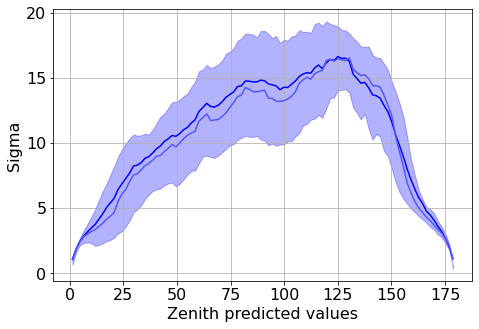

In [23]:
plt.close('all')

#Cambio el tamanyo de fuente
plt.rcParams.update({'font.size': 16})

# Cambio el tamanyo de la figura
plt.figure(figsize=(7.5,5))

# Numero de intervalos en los que agrupo los datos
n_bins = 100

x, y, x_err, y_err = smooth_values (zenith_p, zenith_std, n_bins) #cojo los valores
plt.plot(x, y, 'blue')
x, y, q1, q3 = smooth_median (zenith_p, zenith_std, n_bins) #cojo los valores
plt.plot(x, y, '#5555ff')
plt.fill_between(x, q3, q1,color='blue',alpha=0.3)

#plt.ylim(0.0, 25.0)
plt.ylabel('Sigma')
plt.xlabel('Zenith predicted values')
#plt.legend(("Model error", 'Model error deviation'),loc='upper right')
plt.grid()

# Guardo la figura y la muestro
plt.savefig('fig/'+red+'/epsilon_PI_Zenith.png')
plt.show(); #muestro las figuras

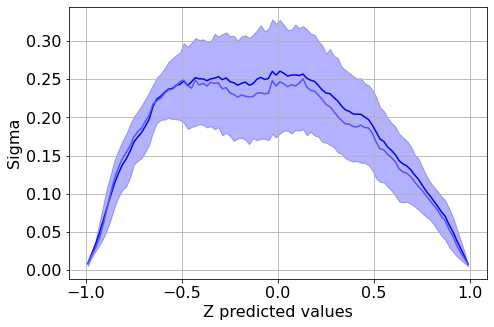

In [24]:
plt.close('all')

#Cambio el tamanyo de fuente
plt.rcParams.update({'font.size': 16})

# Cambio el tamanyo de la figura
plt.figure(figsize=(7.5,5))

# Numero de intervalos en los que agrupo los datos
n_bins = 100

x, y, x_err, y_err = smooth_values (zeta, zeta_std, n_bins) #cojo los valores
plt.plot(x, y, 'blue')
x, y, q1, q3 = smooth_median (zeta, zeta_std, n_bins) #cojo los valores
plt.plot(x, y, '#5555ff')
plt.fill_between(x, q3, q1,color='blue',alpha=0.3)

#plt.ylim(0.0, 0.15)
plt.ylabel('Sigma')
plt.xlabel('Z predicted values')
#plt.legend(("Model error", 'Model error deviation'),loc='upper right')
plt.grid()


# Guardo la figura y la muestro
plt.savefig('fig/'+red+'/epsilon_PI_Z.png')
plt.show(); #muestro las figuras

### Plots en función de Zeta

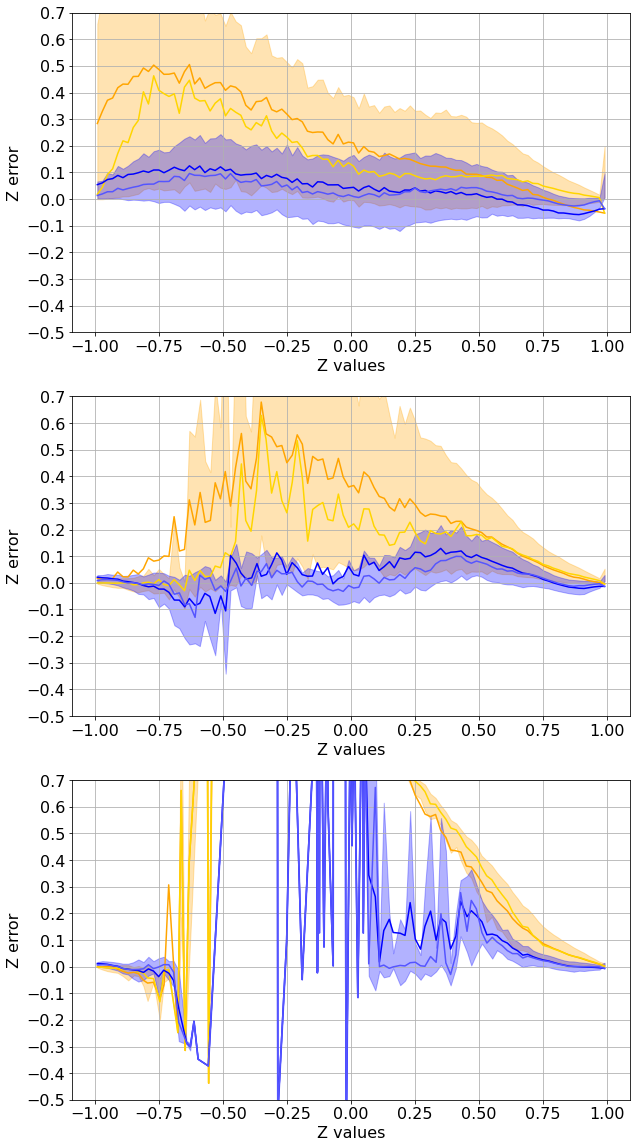

In [25]:
plt.close('all')
plt.figure(figsize=(10,20))
plt.rcParams.update({'font.size': 16})

value = y_test[:,2]
n_bins = 100

plt.subplot(3, 1, 1)
x, y, x_err, y_err = smooth_values (value, bbfit_zeta_error, n_bins) #cojo los valores
plt.plot(x, y,'orange')
x, y, q1, q3 = smooth_median (value, bbfit_zeta_error, n_bins) #cojo los valores
plt.plot(x, y, '#ffd500')
plt.fill_between(x, q3, q1,color='orange',alpha=0.3)

x, y, x_err, y_err = smooth_values (value, zeta_error, n_bins) #cojo los valores
plt.plot(x, y,'blue')
x, y, q1, q3 = smooth_median (value, zeta_error, n_bins) #cojo los valores
plt.plot(x, y, '#5555ff')
plt.fill_between(x, q3, q1,color='blue',alpha=0.3)

plt.yticks(np.linspace(-0.5, 0.7, num=13, endpoint=True ))
plt.ylim(-0.5, 0.7)
plt.ylabel('Z error')
plt.xlabel('Z values')
#plt.legend(("BBfit error","Model (ReLU) error",'BBfit error deviation', 'Model (ReLU) error deviation'),loc='upper right')
plt.grid(which='both')

pct = 0.5
casos = int(pct*len(y_predict[0]))

z_msk = zeta_std < np.sort(zeta_std)[casos]
z_msk_bb = txi2 < np.sort(txi2)[casos]


plt.subplot(3, 1, 2)
x, y, x_err, y_err = smooth_values (value[z_msk_bb], bbfit_zeta_error[z_msk_bb], n_bins) #cojo los valores
plt.plot(x, y,'orange')
x, y, q1, q3 = smooth_median (value[z_msk_bb], bbfit_zeta_error[z_msk_bb], n_bins) #cojo los valores
plt.plot(x, y, '#ffd500')
plt.fill_between(x, q3, q1,color='orange',alpha=0.3)

x, y, x_err, y_err = smooth_values (value[z_msk], zeta_error[z_msk], n_bins) #cojo los valores
plt.plot(x, y,'blue')
x, y, q1, q3 = smooth_median (value[z_msk], zeta_error[z_msk], n_bins) #cojo los valores
plt.plot(x, y, '#5555ff')
plt.fill_between(x, q3, q1,color='blue',alpha=0.3)

plt.yticks(np.linspace(-0.5, 0.7, num=13, endpoint=True ))
plt.ylim(-0.5, 0.7)
plt.ylabel('Z error')
plt.xlabel('Z values')
#plt.legend(("BBfit error","Model (ReLU) error",'BBfit error deviation', 'Model (ReLU) error deviation'),loc='upper right')
plt.grid(which='both')

pct = 0.25
casos = int(pct*len(y_predict[0]))

z_msk = zeta_std < np.sort(zeta_std)[casos]
z_msk_bb = txi2 < np.sort(txi2)[casos]

plt.subplot(3, 1, 3)
x, y, x_err, y_err = smooth_values (value[z_msk_bb], bbfit_zeta_error[z_msk_bb], n_bins) #cojo los valores
plt.plot(x, y,'orange')
x, y, q1, q3 = smooth_median (value[z_msk_bb], bbfit_zeta_error[z_msk_bb], n_bins) #cojo los valores
plt.plot(x, y, '#ffd500')
plt.fill_between(x, q3, q1,color='orange',alpha=0.3)

x, y, x_err, y_err = smooth_values (value[z_msk], zeta_error[z_msk], n_bins) #cojo los valores
plt.plot(x, y,'blue')
x, y, q1, q3 = smooth_median (value[z_msk], zeta_error[z_msk], n_bins) #cojo los valores
plt.plot(x, y, '#5555ff')
plt.fill_between(x, q3, q1,color='blue',alpha=0.3)

plt.yticks(np.linspace(-0.5, 0.7, num=13, endpoint=True ))
plt.ylim(-0.5, 0.7)
plt.ylabel('Z error')
plt.xlabel('Z values')
#plt.legend(("BBfit error","Model (ReLU) error",'BBfit error deviation', 'Model (ReLU) error deviation'),loc='upper right')
plt.grid(which='both')

plt.savefig('fig/'+red+'/zeta.png')
plt.show(); #muestro las figuras

### Plots de Zenith

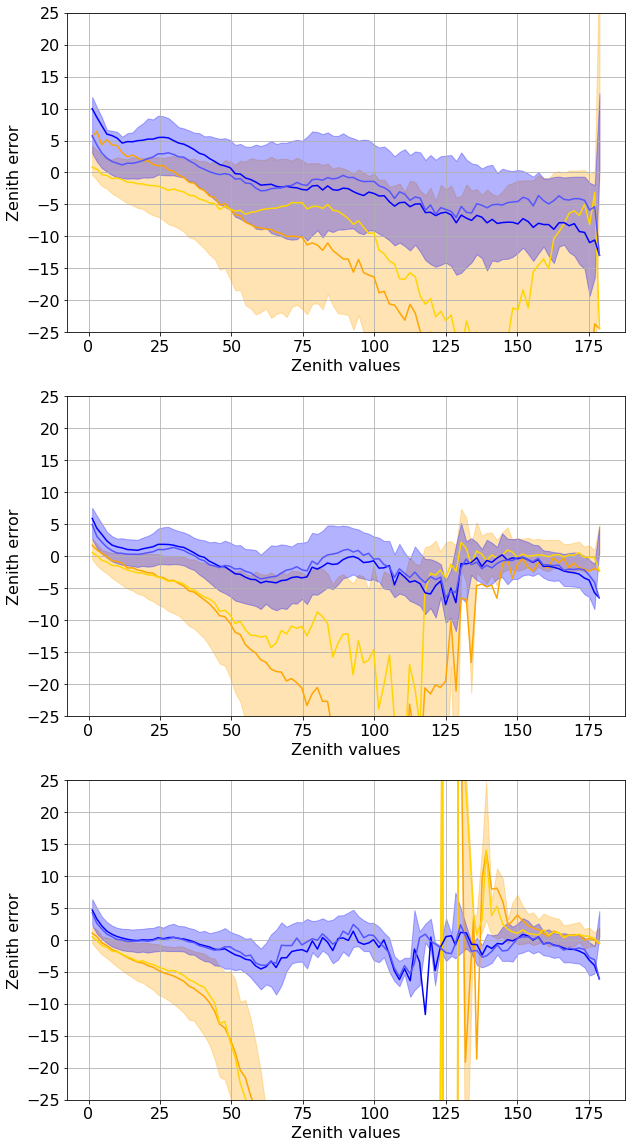

In [26]:
plt.close('all')
plt.figure(figsize=(10,20))
plt.rcParams.update({'font.size': 16})

value = zenith_t
n_bins = 100

plt.subplot(3, 1, 1)
x, y, x_err, y_err = smooth_values (value, bbfit_z_error, n_bins) #cojo los valores
plt.plot(x, y,'orange')
x, y, q1, q3 = smooth_median (value, bbfit_z_error, n_bins) #cojo los valores
plt.plot(x, y, '#ffd500')
plt.fill_between(x, q3, q1,color='orange',alpha=0.3)

x, y, x_err, y_err = smooth_values (value, z_error, n_bins) #cojo los valores
plt.plot(x, y,'blue')
x, y, q1, q3 = smooth_median (value, z_error, n_bins) #cojo los valores
plt.plot(x, y, '#5555ff')
plt.fill_between(x, q3, q1,color='blue',alpha=0.3)

plt.yticks(np.linspace(-25, 25, num=11, endpoint=True ))
plt.ylim(-25, 25)
plt.ylabel('Zenith error')
plt.xlabel('Zenith values')
#plt.legend(("BBfit error","Model (ReLU) error",'BBfit error deviation', 'Model (ReLU) error deviation'),loc='upper right')
plt.grid(which='both')

pct = 0.5
casos = int(pct*len(y_predict[0]))

z_msk = zenith_std < np.sort(zenith_std)[casos]
z_msk_bb = txi2 < np.sort(txi2)[casos]


plt.subplot(3, 1, 2)
x, y, x_err, y_err = smooth_values (value[z_msk_bb], bbfit_z_error[z_msk_bb], n_bins) #cojo los valores
plt.plot(x, y,'orange')
x, y, q1, q3 = smooth_median (value[z_msk_bb], bbfit_z_error[z_msk_bb], n_bins) #cojo los valores
plt.plot(x, y, '#ffd500')
plt.fill_between(x, q3, q1,color='orange',alpha=0.3)

x, y, x_err, y_err = smooth_values (value[z_msk], z_error[z_msk], n_bins) #cojo los valores
plt.plot(x, y,'blue')
x, y, q1, q3 = smooth_median (value[z_msk], z_error[z_msk], n_bins) #cojo los valores
plt.plot(x, y, '#5555ff')
plt.fill_between(x, q3, q1,color='blue',alpha=0.3)

plt.yticks(np.linspace(-25, 25, num=11, endpoint=True ))
plt.ylim(-25, 25)
plt.ylabel('Zenith error')
plt.xlabel('Zenith values')
#plt.legend(("BBfit error","Model (ReLU) error",'BBfit error deviation', 'Model (ReLU) error deviation'),loc='upper right')
plt.grid(which='both')

pct = 0.25
casos = int(pct*len(y_predict[0]))

z_msk = zenith_std < np.sort(zenith_std)[casos]
z_msk_bb = txi2 < np.sort(txi2)[casos]

plt.subplot(3, 1, 3)
x, y, x_err, y_err = smooth_values (value[z_msk_bb], bbfit_z_error[z_msk_bb], n_bins) #cojo los valores
plt.plot(x, y,'orange')
x, y, q1, q3 = smooth_median (value[z_msk_bb], bbfit_z_error[z_msk_bb], n_bins) #cojo los valores
plt.plot(x, y, '#ffd500')
plt.fill_between(x, q3, q1,color='orange',alpha=0.3)

x, y, x_err, y_err = smooth_values (value[z_msk], z_error[z_msk], n_bins) #cojo los valores
plt.plot(x, y,'blue')
x, y, q1, q3 = smooth_median (value[z_msk], z_error[z_msk], n_bins) #cojo los valores
plt.plot(x, y, '#5555ff')
plt.fill_between(x, q3, q1,color='blue',alpha=0.3)

plt.yticks(np.linspace(-25, 25, num=11, endpoint=True ))
plt.ylim(-25, 25)
plt.ylabel('Zenith error')
plt.xlabel('Zenith values')
#plt.legend(("BBfit error","Model (ReLU) error",'BBfit error deviation', 'Model (ReLU) error deviation'),loc='upper right')
plt.grid(which='both')

plt.savefig('fig/'+red+'/zenith.png')
plt.show(); #muestro las figuras

### Density plot Zenith

zenith
ReLU avg: 8.3851, BBfit avg: 15.4838
ReLU std: 9.4650, BBfit std: 18.8418
#####################
Zeta
ReLU avg: 0.1091, BBfit avg: 0.1981
ReLU std: 0.1388, BBfit std: 0.2705
Zenith median:  5.1897583 

Zenith mean:  8.38509 

Zenith quartiles:  2.1119861602783203 11.195960998535156 

#####################
122072 244145 0.4999979520366995
9.659793
#####################
Zeta
ReLU avg: 0.0498, BBfit avg: 0.1014
ReLU std: 0.0683, BBfit std: 0.1572
Zenith median for 0.5 bests sigmas:  3.0132813 

Zenith mean for 0.5 bests sigmas:  4.474047 

Zenith quartiles for 0.5 bests sigmas:  1.3356037139892578 5.91545569896698 



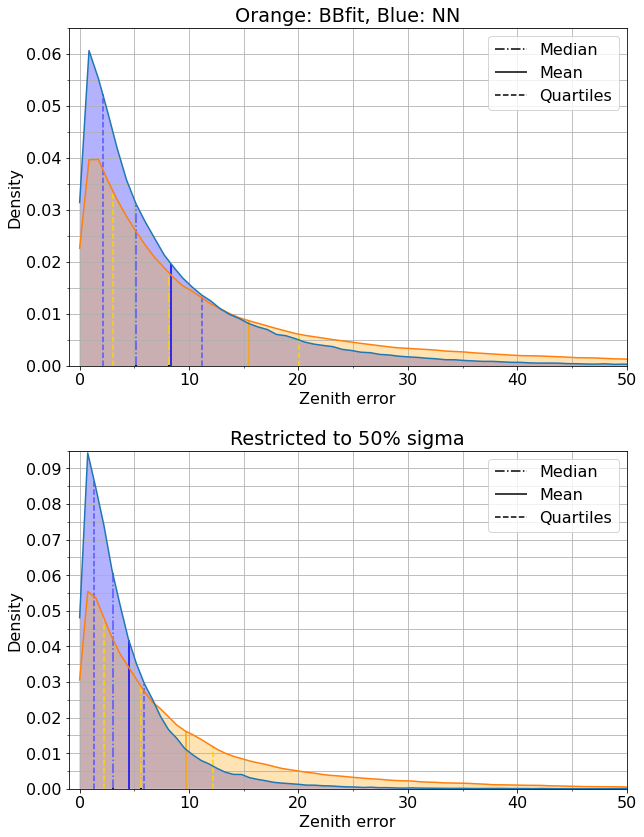

In [27]:
import seaborn as sns
import scipy

plt.close('all')
plt.figure(figsize=(10,14))

print('zenith')
print("ReLU avg: %.4f, BBfit avg: %.4f" % (np.average(z_error_abs), np.average(bbfit_z_error_abs)))
print("ReLU std: %.4f, BBfit std: %.4f" % (np.std(z_error_abs), np.std(bbfit_z_error_abs)))
print('#####################')
print('Zeta')
print("ReLU avg: %.4f, BBfit avg: %.4f" % (np.average(zeta_error_abs), np.average(bbfit_zeta_error_abs)))
print("ReLU std: %.4f, BBfit std: %.4f" % (np.std(zeta_error_abs), np.std(bbfit_zeta_error_abs)))

plt.subplot(2, 1, 1)

p = sns.kdeplot(data=[z_error_abs,bbfit_z_error_abs],cut=0,common_grid=True,common_norm=True, bw_adjust=0.4)
kdeline = p.lines
x, y = kdeline[1].get_xdata(), kdeline[1].get_ydata()
xb, yb = kdeline[0].get_xdata(), kdeline[0].get_ydata()

p.fill_between(x, 0, y, facecolor='blue', alpha=0.3)
p.fill_between(xb, 0, yb, facecolor='orange', alpha=0.3)

# Medians
median = np.median(z_error_abs)
height = np.interp(median, x, y)
plt.vlines(median, 0, height,linestyles='dashdot', color='#5555ff')
plt.vlines(median, 0, 0.0001,linestyles='dashdot', color='black', label='Median')
print('Zenith median: ', median,'\n')

median = np.median(bbfit_z_error_abs)
height = np.interp(median, xb, yb)
plt.vlines(median, 0, height,linestyles='dashdot', color='#ffd500')

#Means
mean = np.mean(z_error_abs)
height = np.interp(mean, x, y)
plt.vlines(mean, 0, height, color='blue')
plt.vlines(median, 0, 0.0001, color='black', label='Mean')
print('Zenith mean: ', mean,'\n')

mean = np.mean(bbfit_z_error_abs)
height = np.interp(mean, xb, yb)
plt.vlines(mean, 0, height, color='orange')

#Quartiles
q1, q3 = np.quantile(z_error_abs,0.25), np.quantile(z_error_abs,0.75)
height1, height3 = np.interp(q1, x, y), np.interp(q3, x, y)
plt.vlines(q1, 0, height1, linestyles='dashed', color='#5555ff')
plt.vlines(q3, 0, height3, linestyles='dashed', color='#5555ff')
plt.vlines(median, 0, 0.0001,linestyles='dashed', color='black', label='Quartiles')
print('Zenith quartiles: ', q1,q3,'\n')

q1, q3 = np.quantile(bbfit_z_error_abs,0.25), np.quantile(bbfit_z_error_abs,0.75)
height1, height3 = np.interp(q1, xb, yb), np.interp(q3, xb, yb)
plt.vlines(q1, 0, height1, linestyles='dashed', color='#ffd500')
plt.vlines(q3, 0, height3, linestyles='dashed', color='#ffd500')

plt.gca().set_xlim(-1,50)
plt.gca().set_ylim(0.0,0.065)
plt.gca().set_title('Orange: BBfit, Blue: NN')
plt.gca().set_xticks(np.linspace(0, 50, num=11, endpoint=True ),minor=True)
plt.gca().set_xticks(np.linspace(0, 50, num=6, endpoint=True ))
plt.gca().set_yticks(np.linspace(0, 0.06, num=7, endpoint=True ))
plt.gca().set_yticks(np.linspace(0, 0.065, num=14, endpoint=True ),minor=True)
plt.xlabel('Zenith error')
plt.grid(which='both',b=True)
plt.legend()


plt.subplot(2, 1, 2)

pct = 0.5
casos = int(pct*len(y_predict[0]))
print('#####################')
print(casos, len(y_predict[0]), casos/len(y_predict[0]))

z_msk = zenith_std < np.sort(zenith_std)[casos]
z_msk_bb = txi2 < np.sort(txi2)[casos]

print(zenith_std[z_msk].max())

print('#####################')
print('Zeta')
print("ReLU avg: %.4f, BBfit avg: %.4f" % (np.average(zeta_error_abs[z_msk]), np.average(bbfit_zeta_error_abs[z_msk_bb])))
print("ReLU std: %.4f, BBfit std: %.4f" % (np.std(zeta_error_abs[z_msk]), np.std(bbfit_zeta_error_abs[z_msk_bb])))

p = sns.kdeplot(data=[z_error_abs[z_msk],bbfit_z_error_abs[z_msk_bb]],cut=0,common_grid=True,common_norm=True, bw_adjust=0.4)
kdeline = p.lines
x, y = kdeline[1].get_xdata(), kdeline[1].get_ydata()
xb, yb = kdeline[0].get_xdata(), kdeline[0].get_ydata()

p.fill_between(x, 0, y, facecolor='blue', alpha=0.3)
p.fill_between(xb, 0, yb, facecolor='orange', alpha=0.3)

# Medians
median = np.median(z_error_abs[z_msk])
height = np.interp(median, x, y)
plt.vlines(median, 0, height,linestyles='dashdot', color='#5555ff')
plt.vlines(median, 0, 0.0001,linestyles='dashdot', color='black', label='Median')
print('Zenith median for 0.5 bests sigmas: ', median,'\n')

median = np.median(bbfit_z_error_abs[z_msk_bb])
height = np.interp(median, xb, yb)
plt.vlines(median, 0, height,linestyles='dashdot', color='#ffd500')

#Means
mean = np.mean(z_error_abs[z_msk])
height = np.interp(mean, x, y)
plt.vlines(mean, 0, height, color='blue')
plt.vlines(median, 0, 0.0001, color='black', label='Mean')
print('Zenith mean for 0.5 bests sigmas: ', mean,'\n')

mean = np.mean(bbfit_z_error_abs[z_msk_bb])
height = np.interp(mean, xb, yb)
plt.vlines(mean, 0, height, color='orange')

#Quartiles
q1, q3 = np.quantile(z_error_abs[z_msk],0.25), np.quantile(z_error_abs[z_msk],0.75)
height1, height3 = np.interp(q1, x, y), np.interp(q3, x, y)
plt.vlines(q1, 0, height1, linestyles='dashed', color='#5555ff')
plt.vlines(q3, 0, height3, linestyles='dashed', color='#5555ff')
plt.vlines(median, 0, 0.0001,linestyles='dashed', color='black', label='Quartiles')
print('Zenith quartiles for 0.5 bests sigmas: ', q1, q3,'\n')

q1, q3 = np.quantile(bbfit_z_error_abs[z_msk_bb],0.25), np.quantile(bbfit_z_error_abs[z_msk_bb],0.75)
height1, height3 = np.interp(q1, xb, yb), np.interp(q3, xb, yb)
plt.vlines(q1, 0, height1, linestyles='dashed', color='#ffd500')
plt.vlines(q3, 0, height3, linestyles='dashed', color='#ffd500')

plt.gca().set_xlim(-1,50)
plt.gca().set_ylim(0.0,0.095)
plt.gca().set_title('Restricted to 50% sigma')
plt.gca().set_xticks(np.linspace(0, 50, num=11, endpoint=True ),minor=True)
plt.gca().set_xticks(np.linspace(0, 50, num=6, endpoint=True ))
plt.gca().set_yticks(np.linspace(0, 0.095, num=20, endpoint=True ),minor=True)
plt.gca().set_yticks(np.linspace(0, 0.09, num=10, endpoint=True ))
plt.xlabel('Zenith error')
plt.grid(which='both',b=True)
plt.legend()

plt.subplots_adjust(hspace=0.25,wspace=0.3)
plt.savefig('fig/'+red+'/density_Zenith.png')
plt.show;


Zenith
ReLU avg: 8.3851, BBfit avg: 15.4838
ReLU std: 9.4650, BBfit std: 18.8418
#####################
Zeta
ReLU avg: 0.1091, BBfit avg: 0.1981
ReLU std: 0.1388, BBfit std: 0.2705
#####################
122072 244145 0.4999979520366995
#####################
Zeta
ReLU avg: 0.0470, BBfit avg: 0.1014
ReLU std: 0.0678, BBfit std: 0.1572


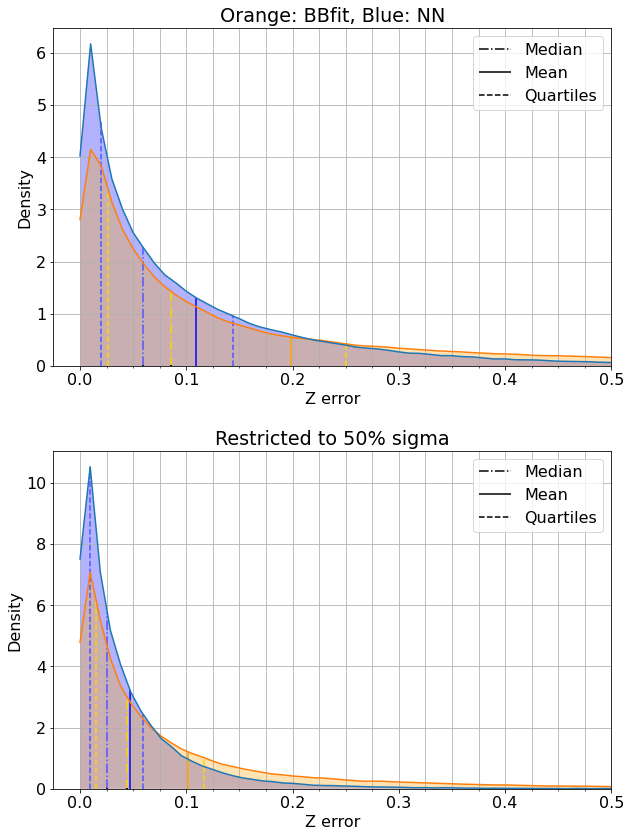

In [28]:
import seaborn as sns
import scipy

plt.close('all')
plt.figure(figsize=(10,14))

print('Zenith')
print("ReLU avg: %.4f, BBfit avg: %.4f" % (np.average(z_error_abs), np.average(bbfit_z_error_abs)))
print("ReLU std: %.4f, BBfit std: %.4f" % (np.std(z_error_abs), np.std(bbfit_z_error_abs)))
print('#####################')
print('Zeta')
print("ReLU avg: %.4f, BBfit avg: %.4f" % (np.average(zeta_error_abs), np.average(bbfit_zeta_error_abs)))
print("ReLU std: %.4f, BBfit std: %.4f" % (np.std(zeta_error_abs), np.std(bbfit_zeta_error_abs)))

plt.subplot(2, 1, 1)

p = sns.kdeplot(data=[zeta_error_abs,bbfit_zeta_error_abs],cut=0,common_grid=True,common_norm=True, bw_adjust=0.4)
kdeline = p.lines
x, y = kdeline[1].get_xdata(), kdeline[1].get_ydata()
xb, yb = kdeline[0].get_xdata(), kdeline[0].get_ydata()

p.fill_between(x, 0, y, facecolor='blue', alpha=0.3)
p.fill_between(xb, 0, yb, facecolor='orange', alpha=0.3)

# Medians
median = np.median(zeta_error_abs)
height = np.interp(median, x, y)
plt.vlines(median, 0, height,linestyles='dashdot', color='#5555ff')
plt.vlines(median, 0, 0.01,linestyles='dashdot', color='black', label='Median')

median = np.median(bbfit_zeta_error_abs)
height = np.interp(median, xb, yb)
plt.vlines(median, 0, height,linestyles='dashdot', color='#ffd500')

#Means
mean = np.mean(zeta_error_abs)
height = np.interp(mean, x, y)
plt.vlines(mean, 0, height, color='blue')
plt.vlines(median, 0, 0.01, color='black', label='Mean')

mean = np.mean(bbfit_zeta_error_abs)
height = np.interp(mean, xb, yb)
plt.vlines(mean, 0, height, color='orange')

#Quartiles
q1, q3 = np.quantile(zeta_error_abs,0.25), np.quantile(zeta_error_abs,0.75)
height1, height3 = np.interp(q1, x, y), np.interp(q3, x, y)
plt.vlines(q1, 0, height1, linestyles='dashed', color='#5555ff')
plt.vlines(q3, 0, height3, linestyles='dashed', color='#5555ff')
plt.vlines(median, 0, 0.01,linestyles='dashed', color='black', label='Quartiles')

q1, q3 = np.quantile(bbfit_zeta_error_abs,0.25), np.quantile(bbfit_zeta_error_abs,0.75)
height1, height3 = np.interp(q1, xb, yb), np.interp(q3, xb, yb)
plt.vlines(q1, 0, height1, linestyles='dashed', color='#ffd500')
plt.vlines(q3, 0, height3, linestyles='dashed', color='#ffd500')

plt.gca().set_xlim(-0.025,0.5)
plt.gca().set_title('Orange: BBfit, Blue: NN')
plt.gca().set_xticks(np.linspace(0, 0.5, num=21, endpoint=True ),minor=True)
plt.gca().set_xticks(np.linspace(0, 0.5, num=6, endpoint=True ))
plt.xlabel('Z error')
plt.grid(which='both',b=True)
plt.legend()


plt.subplot(2, 1, 2)

pct = 0.5
casos = int(pct*len(y_predict[0]))
print('#####################')
print(casos, len(y_predict[0]), casos/len(y_predict[0]))

z_msk = zeta_std < np.sort(zeta_std)[casos]
z_msk_bb = txi2 < np.sort(txi2)[casos]

print('#####################')
print('Zeta')
print("ReLU avg: %.4f, BBfit avg: %.4f" % (np.average(zeta_error_abs[z_msk]), np.average(bbfit_zeta_error_abs[z_msk_bb])))
print("ReLU std: %.4f, BBfit std: %.4f" % (np.std(zeta_error_abs[z_msk]), np.std(bbfit_zeta_error_abs[z_msk_bb])))

p = sns.kdeplot(data=[zeta_error_abs[z_msk],bbfit_zeta_error_abs[z_msk_bb]],cut=0,common_grid=True,common_norm=True, bw_adjust=0.4)
kdeline = p.lines
x, y = kdeline[1].get_xdata(), kdeline[1].get_ydata()
xb, yb = kdeline[0].get_xdata(), kdeline[0].get_ydata()

p.fill_between(x, 0, y, facecolor='blue', alpha=0.3)
p.fill_between(xb, 0, yb, facecolor='orange', alpha=0.3)

# Medians
median = np.median(zeta_error_abs[z_msk])
height = np.interp(median, x, y)
plt.vlines(median, 0, height,linestyles='dashdot', color='#5555ff')
plt.vlines(median, 0, 0.01,linestyles='dashdot', color='black', label='Median')

median = np.median(bbfit_zeta_error_abs[z_msk_bb])
height = np.interp(median, xb, yb)
plt.vlines(median, 0, height,linestyles='dashdot', color='#ffd500')

#Means
mean = np.mean(zeta_error_abs[z_msk])
height = np.interp(mean, x, y)
plt.vlines(mean, 0, height, color='blue')
plt.vlines(median, 0, 0.01, color='black', label='Mean')

mean = np.mean(bbfit_zeta_error_abs[z_msk_bb])
height = np.interp(mean, xb, yb)
plt.vlines(mean, 0, height, color='orange')

#Quartiles
q1, q3 = np.quantile(zeta_error_abs[z_msk],0.25), np.quantile(zeta_error_abs[z_msk],0.75)
height1, height3 = np.interp(q1, x, y), np.interp(q3, x, y)
plt.vlines(q1, 0, height1, linestyles='dashed', color='#5555ff')
plt.vlines(q3, 0, height3, linestyles='dashed', color='#5555ff')
plt.vlines(median, 0, 0.01,linestyles='dashed', color='black', label='Quartiles')

q1, q3 = np.quantile(bbfit_zeta_error_abs[z_msk_bb],0.25), np.quantile(bbfit_zeta_error_abs[z_msk_bb],0.75)
height1, height3 = np.interp(q1, xb, yb), np.interp(q3, xb, yb)
plt.vlines(q1, 0, height1, linestyles='dashed', color='#ffd500')
plt.vlines(q3, 0, height3, linestyles='dashed', color='#ffd500')

plt.gca().set_xlim(-0.025,0.5)
plt.gca().set_title('Restricted to 50% sigma')
plt.gca().set_xticks(np.linspace(0, 0.5, num=21, endpoint=True ),minor=True)
plt.gca().set_xticks(np.linspace(0, 0.5, num=6, endpoint=True ))
plt.xlabel('Z error')
plt.grid(which='both',b=True)
plt.legend()


plt.subplots_adjust(hspace=0.25,wspace=0.3)
plt.savefig('fig/'+red+'/density_Z.png')
plt.show;

### Histogramas de Z

122072 244145 0.4999979520366995
61036 244145 0.24999897601834975


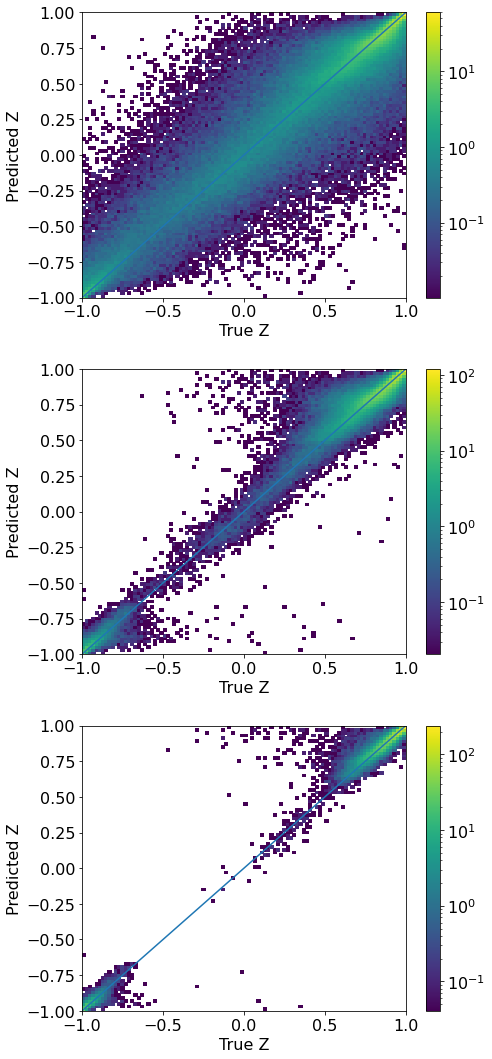

In [29]:
# Histograma de Z cortado con eps
plt.close('all')
plt.figure(figsize=(7,15))
plt.rcParams.update({'font.size': 16})

n_bins = 100

plt.subplot(3, 1, 1)
plt.hist2d(y_test[:,2], zeta, bins = n_bins, density = True, norm = matplotlib.colors.LogNorm())
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.plot(plt.gca().get_xlim(), plt.gca().get_ylim())
plt.ylabel('Predicted Z')
plt.xlabel('True Z')
plt.colorbar()

pct = 0.50
casos = int(pct*len(zeta))
print(casos, len(zeta), casos/len(zeta))

Z_msk = zeta_std < np.sort(zeta_std)[casos]

plt.subplot(3, 1, 2)
plt.hist2d(y_test[:,2][Z_msk], zeta[Z_msk], bins = n_bins, density = True, norm = matplotlib.colors.LogNorm())
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.plot(plt.gca().get_xlim(), plt.gca().get_ylim())
plt.ylabel('Predicted Z')
plt.xlabel('True Z')
plt.colorbar()

pct = 0.25
casos = int(pct*len(zeta))
print(casos, len(zeta), casos/len(zeta))

Z_msk = zeta_std < np.sort(zeta_std)[casos]

plt.subplot(3, 1, 3)
plt.hist2d(y_test[:,2][Z_msk], zeta[Z_msk], bins = n_bins, density = True, norm = matplotlib.colors.LogNorm())
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.plot(plt.gca().get_xlim(), plt.gca().get_ylim())
plt.ylabel('Predicted Z')
plt.xlabel('True Z')
plt.colorbar()
plt.tight_layout()

plt.subplots_adjust(hspace=0.25)
plt.savefig('fig/'+red+'/colors_75_Z_eps.png')
plt.show(); #muestro las figuras

122072 244145 0.4999979520366995
61036 244145 0.24999897601834975


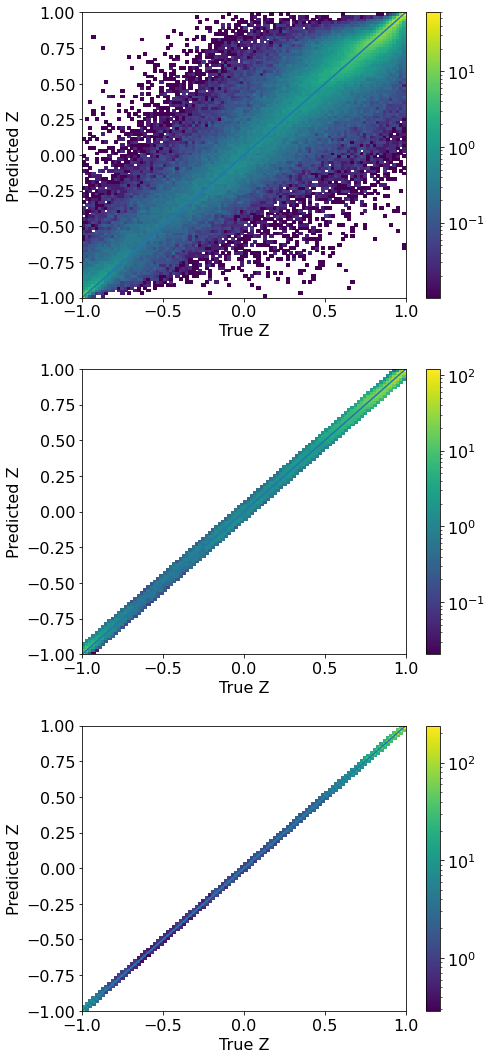

In [30]:
# Histograma de Z cortado con error
plt.close('all')
plt.figure(figsize=(7,15))
plt.rcParams.update({'font.size': 16})

n_bins = 100

plt.subplot(3, 1, 1)
plt.hist2d(y_test[:,2], zeta, bins = n_bins, density = True, norm = matplotlib.colors.LogNorm())
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.plot(plt.gca().get_xlim(), plt.gca().get_ylim())
plt.ylabel('Predicted Z')
plt.xlabel('True Z')
plt.colorbar()

pct = 0.50
casos = int(pct*len(zeta))
print(casos, len(zeta), casos/len(zeta))

Z_msk = zeta_error_abs < np.sort(zeta_error_abs)[casos]

plt.subplot(3, 1, 2)
plt.hist2d(y_test[:,2][Z_msk], zeta[Z_msk], bins = n_bins, density = True, norm = matplotlib.colors.LogNorm())
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.plot(plt.gca().get_xlim(), plt.gca().get_ylim())
plt.ylabel('Predicted Z')
plt.xlabel('True Z')
plt.colorbar()

pct = 0.25
casos = int(pct*len(zeta))
print(casos, len(zeta), casos/len(zeta))

Z_msk = zeta_error_abs < np.sort(zeta_error_abs)[casos]

plt.subplot(3, 1, 3)
plt.hist2d(y_test[:,2][Z_msk], zeta[Z_msk], bins = n_bins, density = True, norm = matplotlib.colors.LogNorm())
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.plot(plt.gca().get_xlim(), plt.gca().get_ylim())
plt.ylabel('Predicted Z')
plt.xlabel('True Z')
plt.colorbar()
plt.tight_layout()

plt.subplots_adjust(hspace=0.25)
plt.savefig('fig/'+red+'/colors_75_Z_error.png')
plt.show(); #muestro las figuras

### Histogramas 2D de zenith

29.589094960351268
50.453830526246804


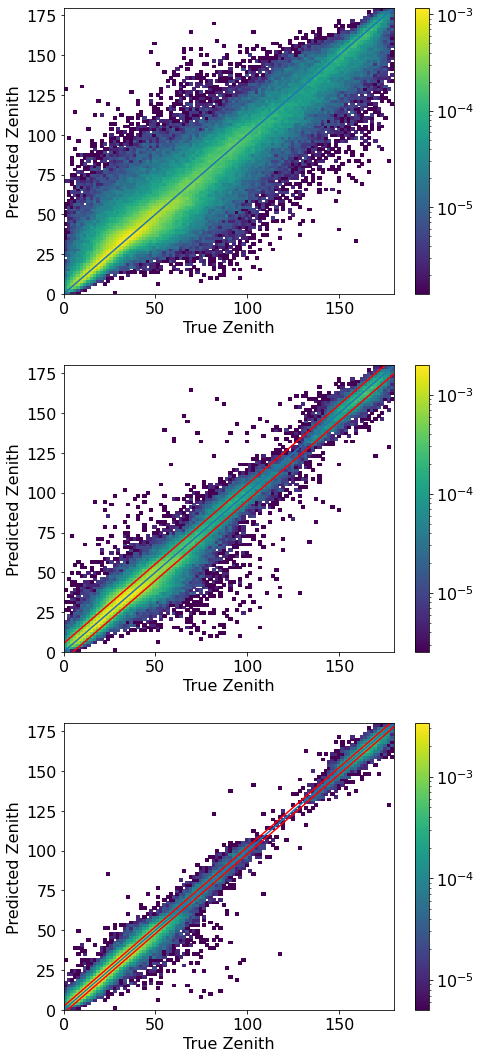

In [31]:
#histograma de zenith cortado con eps
plt.close('all')
plt.figure(figsize=(7,15))
plt.rcParams.update({'font.size': 16})

n_bins = 100

plt.subplot(3, 1, 1)
plt.hist2d(zenith_t, zenith_p, bins = n_bins, density = True, norm = matplotlib.colors.LogNorm())
plt.xlim(0,180)
plt.ylim(0,180)
plt.plot(plt.gca().get_xlim(), plt.gca().get_ylim())
plt.ylabel('Predicted Zenith')
plt.xlabel('True Zenith')
plt.colorbar()

pct = 0.50
casos = int(pct*len(y_predict[0]))

Z_msk = zenith_std < np.sort(zenith_std)[casos]
a_msk = z_error_abs < np.sort(z_error_abs)[casos]
a = z_error_abs[a_msk].max()

print(np.sum(z_error_abs[Z_msk]> a)*100/casos)

plt.subplot(3, 1, 2)
plt.hist2d(zenith_t[Z_msk],zenith_p[Z_msk], bins = n_bins, density = True, norm = matplotlib.colors.LogNorm())
plt.xlim(0,180)
plt.ylim(0,180)
plt.plot(plt.gca().get_xlim(), plt.gca().get_ylim())
plt.plot(plt.gca().get_xlim()+a,plt.gca().get_ylim(), color='red')
plt.plot(plt.gca().get_xlim()-a,plt.gca().get_ylim(), color='red')
plt.ylabel('Predicted Zenith')
plt.xlabel('True Zenith')
plt.colorbar()

pct = 0.25
casos = int(pct*len(y_predict[0]))

Z_msk = zenith_std < np.sort(zenith_std)[casos]
a_msk = z_error_abs < np.sort(z_error_abs)[casos]
a = z_error_abs[a_msk].max()

print(np.sum(z_error_abs[Z_msk]> a)*100/casos)

plt.subplot(3, 1, 3)
plt.hist2d(zenith_t[Z_msk],zenith_p[Z_msk], bins = n_bins, density = True, norm = matplotlib.colors.LogNorm())
plt.xlim(0,180)
plt.ylim(0,180)
plt.plot(plt.gca().get_xlim(), plt.gca().get_ylim())
plt.plot(plt.gca().get_xlim()+a,plt.gca().get_ylim(), color='red')
plt.plot(plt.gca().get_xlim()-a,plt.gca().get_ylim(), color='red')
plt.ylabel('Predicted Zenith')
plt.xlabel('True Zenith')
plt.colorbar()

plt.tight_layout()
plt.subplots_adjust(hspace=0.25)
plt.savefig('fig/'+red+'/colors_75_Zenith_eps.png')
plt.show(); #muestro las figuras

122072 244145 0.4999979520366995
61036 244145 0.24999897601834975
2.1119347


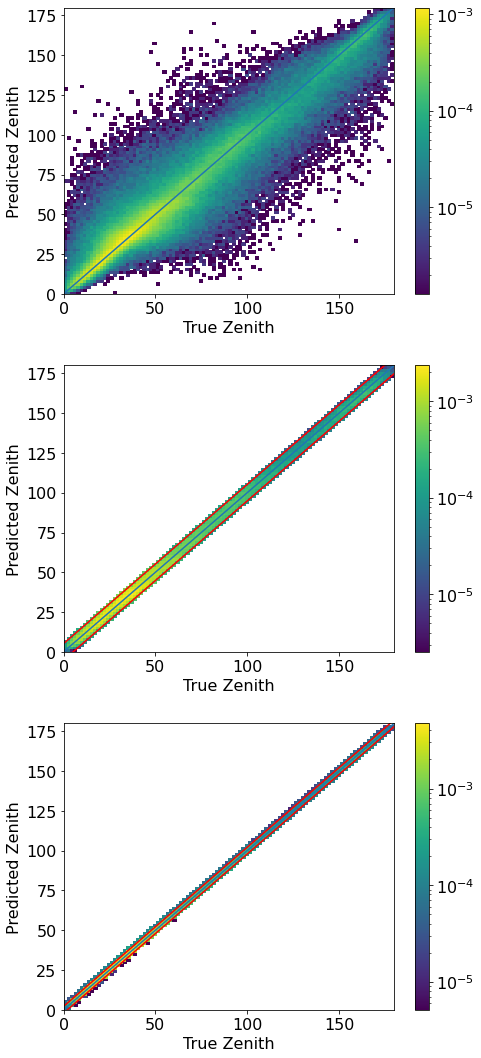

In [32]:
#histograma de zenith cortado con error
plt.close('all')
plt.figure(figsize=(7,15))
plt.rcParams.update({'font.size': 16})

n_bins = 100

plt.subplot(3, 1, 1)
plt.hist2d(zenith_t, zenith_p, bins = n_bins, density = True, norm = matplotlib.colors.LogNorm())
plt.xlim(0,180)
plt.ylim(0,180)
plt.plot(plt.gca().get_xlim(), plt.gca().get_ylim())
plt.ylabel('Predicted Zenith')
plt.xlabel('True Zenith')
plt.colorbar()

pct = 0.50
casos = int(pct*len(y_predict[0]))
print(casos, len(y_predict[0]), casos/len(y_predict[0]))

Z_msk = z_error_abs < np.sort(z_error_abs)[casos]
a = z_error_abs[Z_msk].max()

plt.subplot(3, 1, 2)
plt.hist2d(zenith_t[Z_msk],zenith_p[Z_msk], bins = n_bins, density = True, norm = matplotlib.colors.LogNorm())
plt.xlim(0,180)
plt.ylim(0,180)
plt.plot(plt.gca().get_xlim(), plt.gca().get_ylim())
plt.plot(plt.gca().get_xlim()+a,plt.gca().get_ylim(), color='red')
plt.plot(plt.gca().get_xlim()-a,plt.gca().get_ylim(), color='red')
plt.ylabel('Predicted Zenith')
plt.xlabel('True Zenith')
plt.colorbar()

pct = 0.25
casos = int(pct*len(y_predict[0]))
print(casos, len(y_predict[0]), casos/len(y_predict[0]))

Z_msk = z_error_abs < np.sort(z_error_abs)[casos]
a = z_error_abs[Z_msk].max()
print(a)

plt.subplot(3, 1, 3)
plt.hist2d(zenith_t[Z_msk],zenith_p[Z_msk], bins = n_bins, density = True, norm = matplotlib.colors.LogNorm())
plt.xlim(0,180)
plt.ylim(0,180)
plt.plot(plt.gca().get_xlim(), plt.gca().get_ylim())

plt.plot((0,180)+a,plt.gca().get_ylim(), color='red')
plt.plot(plt.gca().get_xlim()-a,plt.gca().get_ylim(), color='red')

plt.ylabel('Predicted Zenith')
plt.xlabel('True Zenith')
plt.colorbar()

plt.tight_layout()
plt.subplots_adjust(hspace=0.25)
plt.savefig('fig/'+red+'/colors_75_Zenith_error.png')
plt.show(); #muestro las figuras

### Histogramas de Z BBfit

122072 244145 0.4999979520366995
38.6640671079363
61036 244145 0.24999897601834975
59.94658889835507


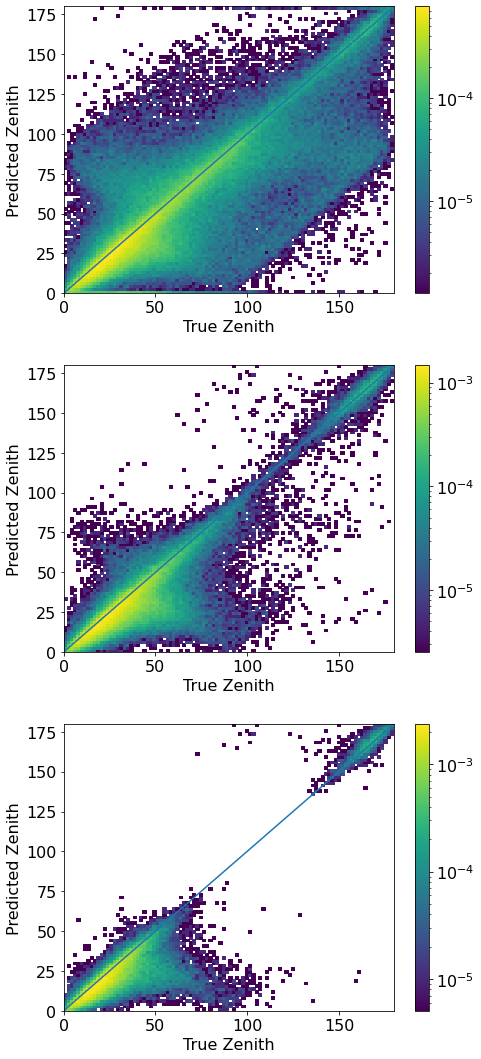

In [33]:
plt.close('all')
plt.figure(figsize=(7,15))
plt.rcParams.update({'font.size': 16})

n_bins = 100

plt.subplot(3, 1, 1)
plt.hist2d(zenith_t, bbfit_z_p, bins = n_bins, density = True, norm = matplotlib.colors.LogNorm())
plt.xlim(0,180)
plt.ylim(0,180)
plt.plot(plt.gca().get_xlim(), plt.gca().get_ylim())
plt.ylabel('Predicted Zenith')
plt.xlabel('True Zenith')
plt.colorbar()

pct = 0.50
casos = int(pct*len(bbfit_uz))
print(casos, len(bbfit_uz), casos/len(bbfit_uz))

Z_msk = txi2< np.sort(txi2)[casos]
a_msk = z_error_abs < np.sort(z_error_abs)[casos]
a = z_error_abs[a_msk].max()

print(np.sum(z_error_abs[Z_msk]> a)*100/casos)

plt.subplot(3, 1, 2)
plt.hist2d(zenith_t[Z_msk], bbfit_z_p[Z_msk], bins = n_bins, density = True, norm = matplotlib.colors.LogNorm())
plt.xlim(0,180)
plt.ylim(0,180)
plt.plot(plt.gca().get_xlim(), plt.gca().get_ylim())
plt.ylabel('Predicted Zenith')
plt.xlabel('True Zenith')
plt.colorbar()

pct = 0.25
casos = int(pct*len(bbfit_uz))
print(casos, len(bbfit_uz), casos/len(bbfit_uz))

Z_msk = txi2< np.sort(txi2)[casos]
a_msk = z_error_abs < np.sort(z_error_abs)[casos]
a = z_error_abs[a_msk].max()

print(np.sum(z_error_abs[Z_msk]> a)*100/casos)

plt.subplot(3, 1, 3)
plt.hist2d(zenith_t[Z_msk], bbfit_z_p[Z_msk], bins = n_bins, density = True, norm = matplotlib.colors.LogNorm())
plt.xlim(0,180)
plt.ylim(0,180)
plt.plot(plt.gca().get_xlim(), plt.gca().get_ylim())
plt.ylabel('Predicted Zenith')
plt.xlabel('True Zenith')
plt.colorbar()

plt.tight_layout()
plt.subplots_adjust(hspace=0.25)
plt.savefig('fig/'+red+'/colors_75_Zenith_bb.png')
plt.show(); #muestro las figuras

122072 244145 0.4999979520366995
61036 244145 0.24999897601834975


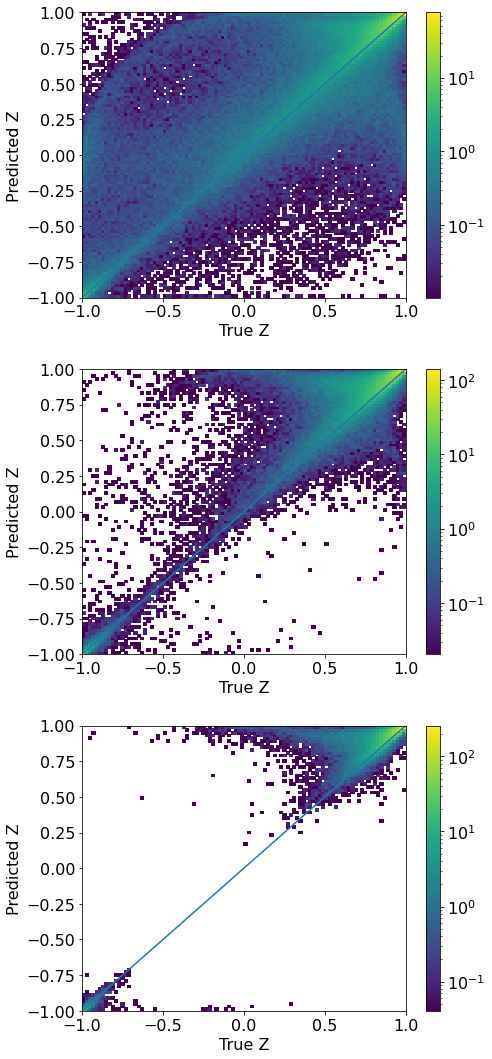

In [34]:
plt.close('all')
plt.figure(figsize=(7,15))
plt.rcParams.update({'font.size': 16})

n_bins = 100

plt.subplot(3, 1, 1)
plt.hist2d(y_test[:,2], bbfit_uz, bins = n_bins, density = True, norm = matplotlib.colors.LogNorm())
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.plot(plt.gca().get_xlim(), plt.gca().get_ylim())
plt.ylabel('Predicted Z')
plt.xlabel('True Z')
plt.colorbar()

pct = 0.50
casos = int(pct*len(bbfit_uz))
print(casos, len(bbfit_uz), casos/len(bbfit_uz))

Z_msk = txi2< np.sort(txi2)[casos]

plt.subplot(3, 1, 2)
plt.hist2d(y_test[:,2][Z_msk], bbfit_uz[Z_msk], bins = n_bins, density = True, norm = matplotlib.colors.LogNorm())
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.plot(plt.gca().get_xlim(), plt.gca().get_ylim())
plt.ylabel('Predicted Z')
plt.xlabel('True Z')
plt.colorbar()

pct = 0.25
casos = int(pct*len(bbfit_uz))
print(casos, len(bbfit_uz), casos/len(bbfit_uz))

Z_msk = txi2< np.sort(txi2)[casos]

plt.subplot(3, 1, 3)
plt.hist2d(y_test[:,2][Z_msk], bbfit_uz[Z_msk], bins = n_bins, density = True, norm = matplotlib.colors.LogNorm())
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.plot(plt.gca().get_xlim(), plt.gca().get_ylim())
plt.ylabel('Predicted Z')
plt.xlabel('True Z')
plt.colorbar()

plt.tight_layout()
plt.subplots_adjust(hspace=0.25)
plt.savefig('fig/'+red+'/colors_75_Z_bb.png')
plt.show(); #muestro las figuras

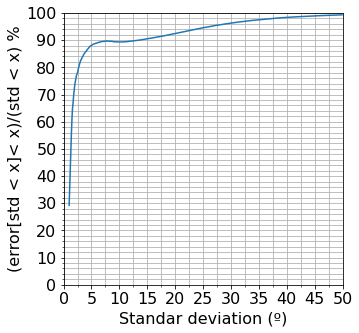

In [35]:
plt.close('all')
plt.figure(figsize=(5,5))
plt.rcParams.update({'font.size': 16})

x = np.arange(1,50,0.1)
y = np.zeros(x.shape)

count = 0
for i in x:
    y[count] = np.sum(z_error_abs[zenith_std<i] < i)*100/np.sum(zenith_std < i)
    count += 1

plt.plot(x,y)
plt.xlim(0,50)
plt.ylim(0,100)
plt.ylabel('(error[std < x]< x)/(std < x) %')
plt.xlabel('Standar deviation (º)')

plt.gca().set_xticks(np.linspace(0, 50, num=21, endpoint=True ),minor=True)
plt.gca().set_xticks(np.linspace(0, 50, num=11, endpoint=True ))
plt.gca().set_yticks(np.linspace(0, 100, num=51, endpoint=True ),minor=True)
plt.gca().set_yticks(np.linspace(0, 100, num=11, endpoint=True ))
plt.grid(which='both',b=True)

plt.show();